# Plant core genes lost with parasitism

## Method

* Orthologous Groups were inferred using [SonicParanoid2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-024-03298-4) (graph-based only)

## Dataset

* 5 hemi-parasitic plants
* 5 holo-parasitic plants
* 18 non-parasitic plant (One per order of the Pentapetalae)

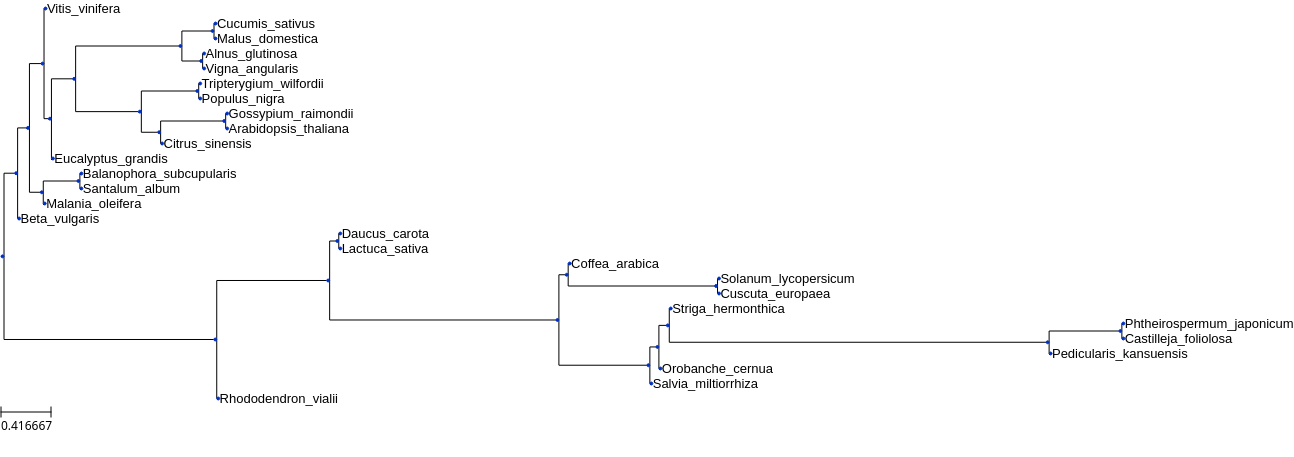

In [ ]:
# import ete3 as ete

# t = ete.Tree("data/28species_tree.nwk")
# ts = ete.TreeStyle()
# ts.scale =  120 # 120 pixels per branch length unit
# t.render("%%inline", tree_style=ts)

## Phylogenetic profile of lost core genes

Orthologous groups (OGs) of (non-parasitic) plant core genes are shown in the rows. The 28 plant taxa considered in this analysis are shown in the columns.

Non-parasitic plants are shown in blue, hemi-parasitic plants are shown in grey, and holo-parasitic plants are shown in yellow.

The hoverover information displays the protein_ids assigend to the OG in the corresponding plant species. Additionally, the functional annotation of the ortholog in _A. thaliana_ is shown.

## Parameters

* **Core factor**: Ratio of non-parasitic plants in which a gene must be found to be considered a "core gene"
* **Loss factor**: Ratio of parasitic plants in which a gene must be absent to be considered "lost with parasitism"
* **Annotation**: If "first" show the annotation of the first co-ortholog in _A. thaliana_, if "all" show the annotation of all co-orthologs

In [3]:
import pandas as pd
import json
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

from loading import generate_widgets, get_parasets
from process_core import find_genes_lost_for_parasitism
from prepare_plotting import prepare_for_heatmap
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# --- widgets ---
core_factor, loss_factor, propagate_annotation = generate_widgets()
display(core_factor, loss_factor, propagate_annotation)

# --- input paths ---
para_nonpara_overview = f'data/28taxa_overview.tsv'
og_path = f'data/28taxa_orthogroups.tsv'
ath_anno_path = 'data/ath_protid2annotation.json'

# --- load data (once) ---
taxadf = pd.read_csv(para_nonpara_overview, sep='\t')
nonparasitic, parasitic, holoparasites, hemiparasites = get_parasets(taxadf)
column_names = [f'{name}.fa' for name in hemiparasites + holoparasites]

orthodf = pd.read_csv(og_path, sep='\t')

with open(ath_anno_path) as fh:
    ath_protid2annotation = json.load(fh)

# --- output area for plot ---
out = widgets.Output()
display(out)

# --- function to update the plot ---
def extract_athaliana_protids(df):
    print('# NCBI RefSeq Protein IDs of lost core genes in A. thaliana for enrichment analysis:\n')
    for value in df['Athaliana.fa'].values:
        if ',' in value:
            for coortho in value.split(','):
                print(coortho)
        elif value == '*':
            continue
        else:
            print(value)

def update_plot(change=None):
    with out:
        out.clear_output(wait=True)

        # process data with current widget values
        loss_overview, lost_orthodf = find_genes_lost_for_parasitism(
            orthodf,
            nonparasitic,
            parasitic,
            column_names,
            core_factor=core_factor.value,
            loss_factor=loss_factor.value
        )

        heatmap_df, label_df, anno_df, xlabels, ylabels = prepare_for_heatmap(
            lost_orthodf,
            taxadf,
            ath_protid2annotation,
            propagate_annotation.value,
            nonparasitic,
            hemiparasites,
            holoparasites
        )

        # build heatmap
        fig = go.Figure(data=go.Heatmap(
            z=heatmap_df,
            x=xlabels,
            y=ylabels,
            text=label_df,
            customdata=anno_df,
            hoverinfo='x+text',
            hoverongaps=False,
            showscale=False,
            type='heatmap',
            colorscale='Cividis',
            hovertemplate="<b>%{x}</b><br>%{customdata}<br>%{text}<br><br><extra></extra>",
        ))

        # layout
        row_height = 20
        height = max(400, row_height * heatmap_df.index.size)
        fig.update_layout(
            width=800,
            height=height
        )

        n_rows, n_cols = heatmap_df.shape
        shapes = []
        for i in range(1, n_cols):
            shapes.append(dict(
                type="line",
                x0=i-0.5, x1=i-0.5,
                y0=-0.5, y1=n_rows-0.5,
                line=dict(color="white", width=1)
            ))
        for j in range(1, n_rows):
            shapes.append(dict(
                type="line",
                x0=-0.5, x1=n_cols-0.5,
                y0=j-0.5, y1=j-0.5,
                line=dict(color="white", width=1)
            ))

        fig.update_layout(
            shapes=shapes,
            xaxis=dict(showgrid=False),
            yaxis=dict(showgrid=False, autorange="reversed")
        )

        with out:
            out.clear_output(wait=True)
            ...
            # instead of fig.show():
            display(fig)

# --- connect widgets to update ---
core_factor.observe(update_plot, names="value")
loss_factor.observe(update_plot, names="value")
propagate_annotation.observe(update_plot, names="value")

# --- initial draw ---
update_plot()


FloatSlider(value=0.9, continuous_update=False, description='Core factor:', max=1.0, readout_format='.1f')

FloatSlider(value=0.6, continuous_update=False, description='Loss factor', max=1.0, readout_format='.1f')

Dropdown(description='Annotation:', index=1, options=('full', 'first'), value='first')

Output()